# COMP47590: Advanced Machine Learning
# Assignment 1: Building Heterogenous Ensembles

- Student 1 Name: Finola Cahill
- Student 1 Number: 07645074

## Import Packages

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LinearRegression as LR
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import is_classifier
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.datasets import load_iris
import itertools
from itertools import chain, combinations
import random
from copy import copy
from scipy import stats
from collections import Counter
import collections

import warnings
warnings.filterwarnings('ignore')

## Task 1: The Heterogenous Ensemble Classifier

### Define HeterogenousEnsembleClassifier

In [146]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class HeterogenousEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer. Base models are different due to different hyper-parameters used.

    Parameters
    ----------
    base_estimator: scikit-learn estimator 
        The model type to be used at the base layer of the ensemble model.

    hp_range_map: dictionary
        A dictinary of hyperparamters and the ranges of values that will be used from them
        
    n_estimators: int
        How many models to use in the ensemble
        
    bootstrap: boolean
        Wheter or not to use bootstrap sampling when training base estimators
    
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels.


    Notes
    -----
    The default values for most base learners are used, unless hyperparameter ranges are specified

    See also
    --------
    

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = HeterogenousEnsembleClassifier(tree.DecisionTreeClassifier(), {'max_depth':[5, 10, 15], })
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator = svm.SVC(), n_estimators = 10, hp_range_map = None, bootstrap = True, random_state=None, verbosity = 0):

        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator: The model type to be used at the base layer of the ensemble model.
        hp_range_map: A dictinary of hyperparamters and the ranges of values that will be used from them
        n_estimators: How many models to use in the ensemble
        bootstrap: Wheter or not to use bootstrap sampling when training base estimators
        
        Returns
        -------
        The estimator
        """     

        # Initialise ranomd state if set
        self.random_state = random_state
        
        # Initialise class variabels
        self.base_estimator = base_estimator
        self.hp_range_map = hp_range_map
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.verbosity = verbosity
        self.validate_parameters()
    
    def validate_parameters(self):
        if self.n_estimators < 1:
             raise ValueError("n_estimators must be >= 1")
        if is_classifier(self.base_estimator) is False:
            raise ValueError("base_estimator must be a classifier")
        if self.verbosity not in range(0,3):
            raise ValueError("verbosity has three levels, from 0-2")
        if self.hp_range_map is None:
            self.hp_range_map = {}          

    # The fit function to train a classifier
    def fit(self, X, y):
                
        def checkBootstrap(X, y):
            if self.bootstrap is True:
                return resample(X,y, replace=True)
            return X,y 
                
        def checkValue(value):
            if type(value) is np.ndarray:
                value = value.tolist()
            elif type(value) is not list:
                value = [value]
            return value + [None]
        
        def generate_param_combinations():
            params = []
            for key, value in self.hp_range_map.items():
                params.append(checkValue(value))
                self.keys.append(key)
            product = itertools.product(*params)
            self.params = [ [ p for p in params ] for params in product ] 
        
        def extract_params(n):
            params = {}
            for i,key in enumerate(self.keys):
                if self.params[n][i] is not None:
                    params[key] = self.params[n][i]
            return params
    
        def fit_models(X, y):
            for i in range(0, self.n_estimators):
                X_train, y_train = checkBootstrap(X, y)
                params = extract_params(random.randint(0, (len(self.params)-1)))
                clf = copy(self.base_estimator).set_params(**params)
                self.models.append(clf.fit(X_train, y_train))
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        random.seed(self.random_state)
        
        self.params, self.keys, self.models = [], [], []
        
       #  Count the number of occurrences of each class in the target vector (uses mupy unique function that returns a list of unique values and their counts)
        self.classes_ = np.unique(y)
        
        generate_param_combinations()
        
        fit_models(X,y)
    
        return self

#     # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        
        def interpret_predictions():
            final_prediction = []
            for row in self.ensemble_predictions_.transpose():
                freq, maxi = {}, 0
                prediction, count = np.unique(row, return_counts=True)
                for i,v in enumerate(count):
                    freq[v] = [prediction[i]] if v not in freq else freq[v] + [prediction[i]]
                    maxi = max(maxi, v)
                final_prediction += get_mode(freq,maxi)        
            return final_prediction
    
        def get_mode(frequency, maxi):
            if len(frequency[maxi]) > 1:
                return [frequency[maxi][(random.randint(0, (len(frequency[maxi])-1)))]]
            return frequency[maxi]
    
        check_is_fitted(self, ['models'])
        
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
    
        self.ensemble_predictions_ = np.array([model.predict(X) for model in self.models])
        
        key, val = np.unique(self.ensemble_predictions_, return_counts=True)
        
        results = interpret_predictions()
        
        return np.array(results)

    #     # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        
        check_is_fitted(self, ['models'])
        
        X = check_array(X)
        
        probability = []
    
        self.ensemble_predictions_ = np.array([model.predict(X) for model in self.models])
        
        for p in self.ensemble_predictions_.transpose():
            key, val = np.unique(p, return_counts=True)
            counts = dict(zip(key, val))
            probability.append([(counts[c] / len(p)) if c in counts else 0.0 for c in self.classes_])
        
        return np.array(probability)

### Test the HeterogenousEnsembleClassifier

In [147]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
iris = load_iris()
clf = HeterogenousEnsembleClassifier(n_estimators=40)
clf.fit(iris.data, iris.target)
clf.predict(iris.data)
# clf.predict_proba(iris.data)
# print(x.shape)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Perform a simple test using the HeterogenousEnsembleClassifier on the Iris dataset

In [148]:
iris = load_iris()
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 10), "gamma":[0.1, 0.5], "probability":[True]}
n_estimators = 10
clf = HeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, verbosity = 1)
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
y_pred = clf.predict_proba(iris.data)
y_pred2 = clf.predict(iris.data)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.94      0.98      0.96        50
           2       0.98      0.94      0.96        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,49,1,50
2,0,3,47,50
All,50,52,48,150


Perform a cross validation experiment

In [149]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         1.         0.93333333 0.93333333
 0.86666667 1.         1.         1.        ]
0.9666666666666668  +/-  0.04472135954999579


## Test with non numeric targest

In [150]:
surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()


,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [151]:
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X.shape, y.shape

((306, 3), (306,))

In [152]:
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 10), "gamma":[0.1, 0.5], "probability":[True]}
n_estimators = 10
clf = HeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, verbosity = 1)
clf.fit(X, y)
y_pred = clf.predict(X)

In [153]:
iris.data.shape

(150, 4)

In [154]:
iris.target.shape

(150,)

## Task 2: The StackedHeterogenousEnsembleClassifier Class

### Define StackedHeterogenousEnsembleClassifier Class

In [606]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedHeterogenousEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer. Base models are different due to different hyper-parameters used. Aggrefgattion is perfomred using a stack layer model.

    Parameters
    ----------
    base_estimator: scikit-learn estimator 
        The model type to be used at the base layer of the ensemble model.

    hp_range_map: dictionary
        A dictinary of hyperparamters and the ranges of values that will be used from them
        
    n_estimators: int
        How many models to use in the ensemble
        
    bootstrap: boolean
        Whether or not to use bootstrap sampling wehn training base estimators
    
    stack_layer_estimator: scikit-learn estimator 
        Estimator type of the stack  layer model
        
    base_stack_data_ratio: float
        The ratio with which to split the data for straing the base and stack layers.
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels.

    Notes
    -----
    The default values for most base learners are used, unless hyperparameter ranges are specified

    See also
    --------
    

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedHeterogenousEnsembleClassifier(tree.DecisionTreeClassifier(), {'max_depth':[5, 10, 15], })
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator = svm.SVC(), n_estimators = 10, hp_range_map = None, bootstrap = True, stack_layer_estimator = svm.SVC(), base_stack_data_ratio = 0.7, random_state=None, verbosity = 0):

        """Setup a StackedHeterogenousEnsembleClassifier classifier .
        Parameters
        ----------
        base_estimator: The model type to be used at the base layer of the ensemble model.
        hp_range_map: A dictinary of hyperparamters and the ranges of values that will be used from them
        n_estimators: How many models to use in the ensemble
        bootstrap: Wheter or not to use bootstrap sampling wehn training base estimators
        stack_layer_estimator: Estimator type of the stack  layer model
        base_stack_data_ratio: The ratio with which to split the data for straing the base and stack layers.
        
        Returns
        -------
        The estimator
        """     

        # Initialise ranomd state if set
        self.random_state = random_state
        
        # Initialise class variabels
        self.base_estimator = base_estimator
        self.hp_range_map = hp_range_map
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.stack_layer_estimator = stack_layer_estimator
        self.base_stack_data_ratio = base_stack_data_ratio
        self.verbosity = verbosity
        self.validate_parameters()
        
    
    def validate_parameters(self):
        if self.n_estimators < 1:
             raise ValueError("n_estimators must be >= 1")
        if is_classifier(self.base_estimator) is False:
            raise ValueError("base_estimator must be a classifier")
        if is_classifier(self.stack_layer_estimator) is False:
            raise ValueError("stack_layer_estimator must be a classifier")
        if self.verbosity not in range(0,3):
            raise ValueError("verbosity has range 0-2")
        if self.base_stack_data_ratio <= 0 or self.base_stack_data_ratio >= 1:
            raise ValueError("base_stack_data_ratio must be greater than 0 and smaler than 1.")
        if self.hp_range_map is None:
            self.hp_range_map = {}

    # The fit function to train a classifier
    def fit(self, X, y):

        def checkBootstrap(X, y):
            if self.bootstrap is True:
                return resample(X,y, replace=True)
            return X,y 
        
        def checkValue(value):
            if type(value) is np.ndarray:
                value = value.tolist()
            elif type(value) is not list:
                value = [value]
            return value + [None]
    
        def generate_param_combinations():
            params = []
            for key, value in self.hp_range_map.items():
                params.append(checkValue(value))
                self.keys.append(key)
            product = itertools.product(*params)
            self.params = [ [ p for p in params ] for params in product ] 
        
        def extract_params(n):
            params = {}
            for i,key in enumerate(self.keys):
                if self.params[n][i] is not None:
                    params[key] = self.params[n][i]
            return params
    
        def fit_models(X_train, X_valid, y_train):
            for i in range(0, self.n_estimators):
                X_train, y_train = checkBootstrap(X_train, y_train)
                params = extract_params(random.randint(0, (len(self.params)-1)))
                clf = copy(self.base_estimator).set_params(**params)
                clf.fit(X_train, y_train)
                self.models.append(clf)
                self.model_output.append(clf.predict(X_valid))
            self.model_output = np.asarray(self.model_output)
        
    
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=self.base_stack_data_ratio,
                                                              random_state=self.random_state)

        random.seed(self.random_state)
        
        self.params, self.keys, self.models, self.model_output = [], [], [], []
                
       #  Count the number of occurrences of each class in the target vector (uses mupy unique function that returns a list of unique values and their counts)
        self.classes_ = np.unique(y)

        generate_param_combinations()
        
        fit_models(X_train, X_valid, y_train)
    
        self.model_output = [to_categorical(m, num_classes=len(self.classes_)+1) for m in self.model_output.transpose()]
        
        self.model_output = np.asarray(self.model_output)
        
        print(self.model_output.shape)
        self.model_output = self.model_output.reshape(X_valid.shape[0], self.n_estimators*(len(self.classes_)+1))
        
        self.stack_layer_estimator.fit(self.model_output, y_valid)
        
        return self
        

#     # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        check_is_fitted(self, ['models'])
        
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
    
        self.model_output = np.asarray([m.predict(X) for m in self.models])
        
        self.ensemble_predictions_ = [to_categorical(m, num_classes=len(self.classes_)+1) for m in self.model_output.transpose()]
        
        self.ensemble_predictions_ = np.array(self.ensemble_predictions_)
        self.ensemble_predictions_ = self.ensemble_predictions_.reshape(X.shape[0], (len(self.classes_)+1) * self.n_estimators)
       
    
   
        
#         for i, m in enumerate(self.models):
#             self.ensemble_predictions_[i][m.predict(X)] += 1
        
        return self.stack_layer_estimator.predict(self.ensemble_predictions_)

    
#     # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        
        check_is_fitted(self, ['models'])
        
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
    
        
        self.ensemble_predictions_ = np.array([model.predict(X) for model in self.models])
                
        return(self.stack_layer_estimator.predict_proba(self.ensemble_predictions_.transpose()))
        

In [603]:
from keras.utils.np_utils import to_categorical

n = np.array([1,2,3,2, 2, 1, 2, 0])
print(to_categorical(n))

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


In [604]:
iris = load_iris()
n_estimators = 10
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 0.1), "gamma":[0.1, 0.5], "probability":[True]}
# hyperparam_range = None
clf = StackedHeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, True, svm.SVC(probability=True), 0.7, verbosity = 1)
clf.fit(iris.data, iris.target)
clf.predict(iris.data)


(45, 10, 4)


ValueError: cannot reshape array of size 1800 into shape (45,30)

### Test the StackedHeterogenousEnsembleClassifier

In [590]:
clf.predict_proba(iris.data)

ValueError: X.shape[1] = 10 should be equal to 30, the number of features at training time

Perform a simple test using the StackedHeterogenousEnsembleClassifier on the Iris dataset

In [591]:
iris = load_iris()
n_estimators = 10
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 0.1), "gamma":[0.1, 0.5], "probability":[True]}
clf = StackedHeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, True, svm.SVC(probability=True), 0.7, verbosity = 1)
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
y_pred = clf.predict_proba(iris.data)
y_pred[0:10]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      0.92      0.94        50
           2       0.92      0.96      0.94        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,46,4,50
2,0,2,48,50
All,50,48,52,150


ValueError: X.shape[1] = 10 should be equal to 30, the number of features at training time

Perform a cross validation experiment

In [592]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[0.93333333 0.93333333 1.         1.         1.         0.86666667
 0.86666667 0.93333333 1.         1.        ]
0.9533333333333334  +/-  0.052068331172711015


## Task 3: Compare the Performance of the Different Ensembles Defined

### Load Experiment Dataset

Take only a sample of the dataset for fast testing

In [478]:
data_sampling_rate = .1

Load the dataset and explore it.

In [479]:
dataset = pd.read_csv('Sensorless_drive_diagnosis.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
display(dataset.head())

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F40,F41,F42,F43,F44,F45,F46,F47,F48,label
50059,-0.000003,0.000011,-0.000010,-0.000003,0.000043,-0.000031,-0.034536,-0.034547,-0.034538,-0.021223,...,-0.86202,50.819000,8.1233,-1.4994,-1.4994,-1.4994,-1.4981,-1.4981,-1.4980,10
4165,-0.000021,0.000028,-0.000489,-0.000020,0.000016,-0.000064,0.031218,0.031190,0.031678,-0.044194,...,-0.68506,2.053900,8.4869,-1.5053,-1.5053,-1.5045,-1.4959,-1.4959,-1.4959,1
22543,0.000001,0.000010,0.000019,0.000002,-0.000005,-0.000001,0.019760,0.019750,0.019731,0.021998,...,-0.74117,25.077000,6.5618,-1.4995,-1.4995,-1.4995,-1.4946,-1.4947,-1.4947,5
18920,-0.000005,-0.000101,-0.000284,0.000015,-0.000027,0.000272,0.007367,0.007468,0.007752,0.037450,...,-0.72522,-0.068161,4.6618,-1.4983,-1.4984,-1.4986,-1.5021,-1.5021,-1.5023,4
31030,-0.000016,-0.000001,0.000244,0.000016,0.000038,0.000167,0.006256,0.006257,0.006013,-0.024199,...,-0.60588,4.667300,6.0351,-1.5018,-1.5018,-1.5015,-1.4983,-1.4983,-1.4981,6


In [480]:
print("Missing Values")
print(sum(dataset.isnull().sum()))

Missing Values
0


In [481]:
y = dataset.pop('label')
X = dataset
y.value_counts()/len(y)


10    0.095026
11    0.093488
4     0.093317
1     0.093146
7     0.092634
3     0.092463
5     0.090583
8     0.090412
2     0.088874
9     0.086823
6     0.083234
Name: label, dtype: float64

In [593]:
X_train, X_test, y_train, y_test \
    = train_test_split(X, y, \
                       shuffle=True, \
                       stratify = y, \
                       train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train, y_train, \
                        shuffle=True, \
                        stratify = y_train, \
                        train_size = 0.5/0.7)
print(X_train.shape, X_test.shape, X_valid.shape)

(2925, 48) (1756, 48) (1170, 48)


In [594]:
# Make the min max scalar object
min_max_scaler = preprocessing.MinMaxScaler((-1,1))
min_max_scaler.fit(X_train)

# Train the scalar on the training dataset
a = min_max_scaler.transform(X_train)

# Little trick to stop transform from pandas daataframe to numpy array losing column namesWatch out for putting back in columns here
cols = X_train.columns
X_train = pd.DataFrame(a, columns = cols) 

# Also normalise other partitions
a = min_max_scaler.transform(X_train_plus_valid)
X_train_plus_valid = pd.DataFrame(a, columns = cols) 
a = min_max_scaler.transform(X_valid)
X_valid = pd.DataFrame(a, columns = cols) 
a = min_max_scaler.transform(X_test)
X_test = pd.DataFrame(a, columns = cols) 


In order to develop an initial performance baseline , I decided to compare the performance of the Heterogeneous Ensemble against itself, given four different base classifiers. 
- I decided to use Decision Trees ars they often work well in ensembles. - I then selected kNN as it often does not perform well in ensembles, due to its' stability, and though it would be interesting to see if it performed better with a Heterogeneous Ensemble. 
- SVM is the default classifier given, and hence worth considering in testing. It is also already an ensemble, so it will be interesting to see if the additional diversity produced by the sampling of the hyper paramter space has a significant impact.  
- Finally, I decided to use a logistic regressor, as I have not seen logistic regression frequently used in ensembles, and I was curious as to its' performance. 

In [595]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.ensemble import BaggingClassifier

In [596]:
models = {}
models['DTree'] = DecisionTreeClassifier(random_state=0)
models['kNN'] = KNeighborsClassifier()  
models['SVM'] = svm.SVC(random_state=0)
models['LR'] = LogisticRegression(random_state=0)


In [597]:
##11 hyper parameters each 

In [598]:
hparams = {}
hparams['DTree'] = {'max_depth': list(range(2,100)), 'min_samples_split': list(range(2,50))}
hparams['kNN'] = {'n_neighbors': list(range(3,50)), 'metric': ['euclidean', 'chebyshev', 'minkowski', 'manhattan']}
hparams['SVM'] = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': np.arange(0.1, 10, .1).tolist()}
hparams['LR'] = {'C': np.arange(1.0, 10.0, 0.5).tolist(), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

For this initial test we will be comparing the performance of the ensemble of each classifier against the single classifier itself, and also against a bagged version of the classifier. As an initial measure of performance, we will be looking at the accuracy score when using the valdation set. The parameter ranges have been hand-selected with the goal of provoking the most diversity possible for the heterogenous ensemble. For this initial test, n will be left at the deafult, 10, for both the bootstrapped ensemble and the heterogeneous ensemble. For both the bootstrapped classifier, the default parameters will be used. 

In [607]:
benchmark_1 = pd.DataFrame(columns=[m for m in hparams.keys()],
                            index = ['Single', 'Bootstrapped', 'Ensemble', 'Stacked Ensemble'])

for m in models:
    print(m)
    pred = []
    clf = copy(models[m])
    pred.append(accuracy_score(y_valid, clf.fit(X_train, y_train).predict(X_valid)))
    clf = BaggingClassifier(base_estimator=copy(models[m]), random_state=1)
    pred.append(accuracy_score(y_valid, clf.fit(X_train, y_train).predict(X_valid)))
    clf = HeterogenousEnsembleClassifier(base_estimator=copy(models[m]), hp_range_map=hparams[m],random_state=0)
    pred.append(accuracy_score(y_valid, clf.fit(X_train, y_train).predict(X_valid)))
    clf = StackedHeterogenousEnsembleClassifier(base_estimator=copy(models[m]), hp_range_map=hparams[m],random_state=0)
    pred.append(accuracy_score(y_valid, clf.fit(X_train, y_train).predict(X_valid)))
    benchmark_1[m] = pred



DTree
(878, 10, 12)
kNN
(878, 10, 12)
SVM
(878, 10, 12)
LR
(878, 10, 12)


In [608]:
ranked_benchmark = benchmark_1.copy().rank(ascending=False)
ranked_benchmark['average'] = ranked_benchmark.mean(axis=1)
ranked_benchmark

,DTree,kNN,SVM,LR,average
Single,2.0,2.0,3.0,2.5,2.375
Bootstrapped,1.0,1.0,4.0,2.5,2.125
Ensemble,3.0,3.0,1.0,1.0,2.000
Stacked Ensemble,4.0,4.0,2.0,4.0,3.500


Above, we can see that the bootstrapped clasifiers and the heterogeneous ensemble seem to be perfoming best in terms of the rankings. These rankings do not give us a view on the actual range of performance with regards to accuracy. Below I will plot he accuracy scores to give us a clearer view of their performance. 

In [609]:
benchmark_1

,DTree,kNN,SVM,LR
Single,0.944444,0.841026,0.838462,0.847863
Bootstrapped,0.947009,0.853846,0.835897,0.847863
Ensemble,0.935897,0.754701,0.942735,0.876068
Stacked Ensemble,0.918803,0.746154,0.918803,0.842735


In [43]:
def plot_subplot(fig, ax, title, res):
    X = np.arange(1)
    ax.axhline(y=res.iloc[0], color='red')
    ax.bar(X + 0.00, res.iloc[0], color = 'b', alpha=0.5, width = 0.05, label="Single")
    ax.bar(X + 0.10, res.iloc[1], color = 'y', alpha=0.5, width = 0.05, label = "Bootstrapped")
    ax.bar(X + 0.20, res.iloc[2], color = 'g', alpha=0.5, width = 0.05, label = "Heterogeneous")
    ax.bar(X + 0.30, res.iloc[3], color = 'r', alpha=0.5, width = 0.05, label = "Heterogeneous")
    ax.set_title(title)


IndexError: single positional indexer is out-of-bounds

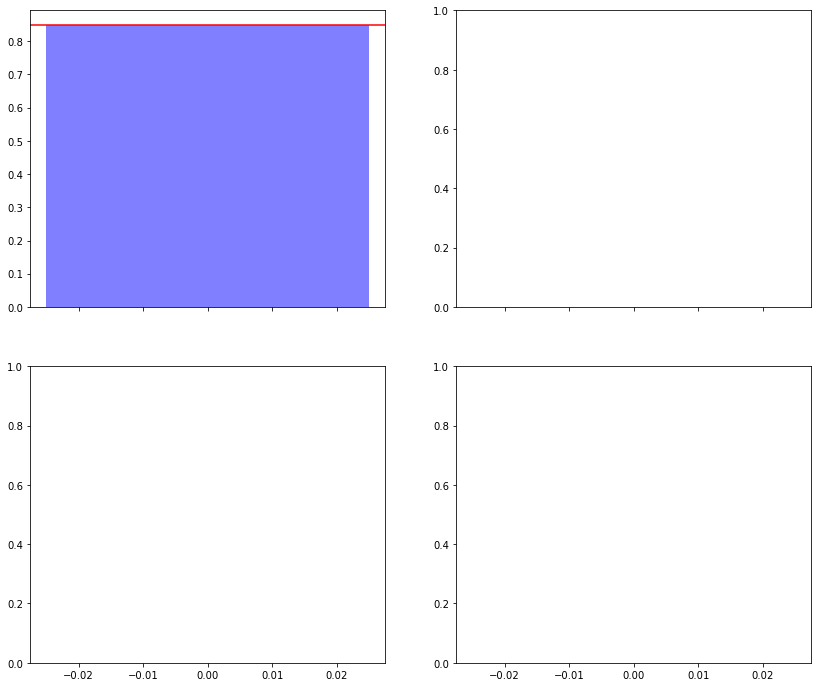

In [44]:
f, axs = plt.subplots(2, 2, figsize=(14,12), sharex=True)
plot_subplot(f, axs[0,0], "Decision Tree", benchmark_1['DTree'])
plot_subplot(f, axs[0,1], "kNN", benchmark_1['kNN'])
plot_subplot(f, axs[1,0], "SVM", benchmark_1['SVM'])
plot_subplot(f, axs[1,1], "Logistic Regression", benchmark_1['LR'])
b = mpatches.Patch(color='blue', alpha=0.5, label='Single')
y = mpatches.Patch(color='yellow', alpha=0.5, label='Bootstrapped')
g = mpatches.Patch(color='green', alpha=0.5, label='Heterogeneous')
r = mpatches.Patch(color='red', alpha=0.5, label='Stacked Heterogeneous')
plt.legend(handles=[b,y,g,r], bbox_to_anchor=(1.05, 1), loc='upper left')
f.suptitle("Accuracy Scores")

- The stacked Heterogeneous model has not performed well in these intiial tests. I suspect that it did not have sufficient data to train the stack successfuly, we will explore this possibility later. 
- The single base estimator has not been ranked first for any classifier. 
- The Heterogeneous model has performed well for Logistic Regression and very well for SVM. For the Decision Tree classifier its' performance is more or less on par with standard bagging. For kNN it has performed particularly poorly. 


I think it would be interesting to next take the base-classifiers that the hetereogeneous ensemble performed worst on, and performed best on, and see if the results fluctuate with cross validation. Given that the stability of this performance is quite dependent on the random seed, I will also vary that to give a wider view on the classifiers.  

In [140]:

def plot_xsection(results, feature, title):
    
    plot_subplot(f, axs[0,0], 0, feature, "Decision Tree", results)
    plot_subplot(f, axs[0,1], 5, feature,"kNN", results)
    plot_subplot(f, axs[1,0], 10, feature,"SVM", results)
    plot_subplot(f, axs[1,1], 15, feature,"Logistic Regression", results)
    b = mpatches.Patch(color='blue', label='N=1')
    g = mpatches.Patch(color='green', label='N=5')
    r = mpatches.Patch(color='red', label='N=10')
    ye = mpatches.Patch(color='yellow', label='N=20')
    k = mpatches.Patch(color='black', label='N=50')
    plt.legend(handles=[b, g, r, ye, k], bbox_to_anchor=(1.05, 1), loc='upper left')
    f.suptitle(title)

In [141]:
from sklearn.metrics import recall_score
def evaluate_model(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='macro')
    return [accuracy, f1, recall]



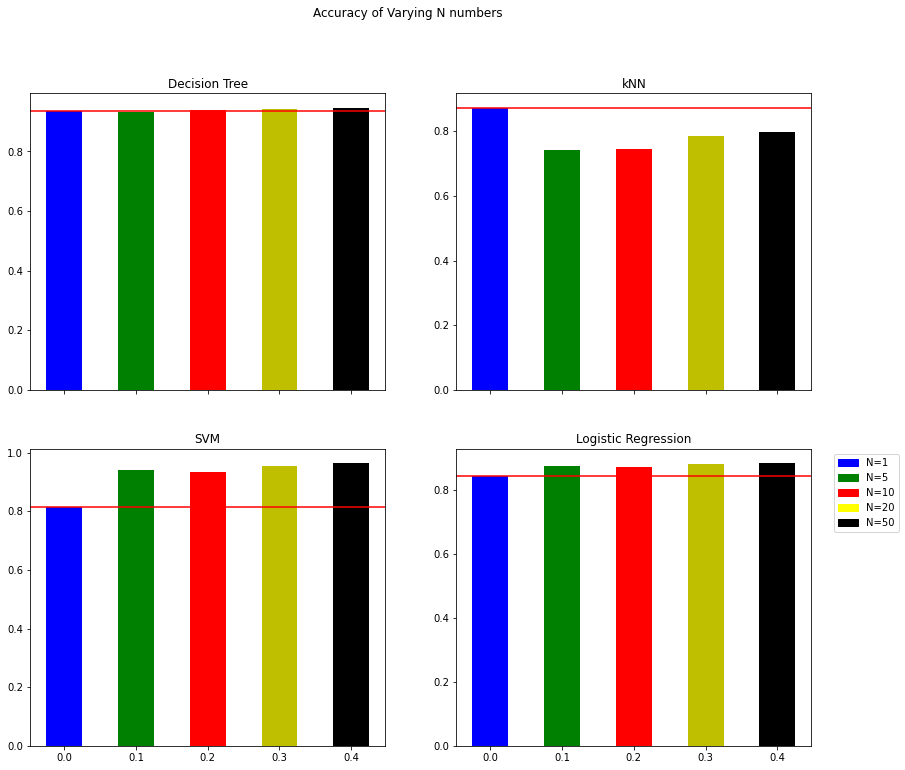

In [142]:
import matplotlib.patches as mpatches

plot_xsection(model_results, 'Accuracy', "Accuracy of Varying N numbers")


In [134]:
reps = 20
clf = svm.SVC(random_state=i)
sv_acc = (cross_val_score(clf, X_valid, y_valid, cv=5).mean())
sv_f1 = (cross_val_score(clf, X_valid, y_valid, cv=5, scoring='f1_macro').mean())

clf = KNeighborsClassifier()
knn_acc = (cross_val_score(clf, X_valid, y_valid, cv=5).mean())
knn_f1 = (cross_val_score(clf, X_valid, y_valid, cv=5, scoring='f1_macro').mean())

k_acc_scores, s_acc_scores = [], []
k_f1_scores, s_f1_scores = [], []
for i in range(reps):
    clf = HeterogenousEnsembleClassifier(base_estimator=models['SVM'], hp_range_map=hparams['SVM'], n_estimators=10, random_state=i)
    s_acc_scores.append(cross_val_score(clf, X_valid, y_valid, cv=5).mean())
    s_f1_scores.append(cross_val_score(clf, X_valid, y_valid, cv=5, scoring='f1_macro').mean())
    clf = HeterogenousEnsembleClassifier(base_estimator=models['kNN'], hp_range_map=hparams['kNN'], n_estimators=10, random_state=i)
    k_acc_scores.append(cross_val_score(clf, X_valid, y_valid, cv=5).mean())
    k_f1_scores.append(cross_val_score(clf, X_valid, y_valid, cv=5, scoring='f1_macro').mean())




NameError: name 'i' is not defined

Text(0.5, 1.0, 'kNN accuracy')

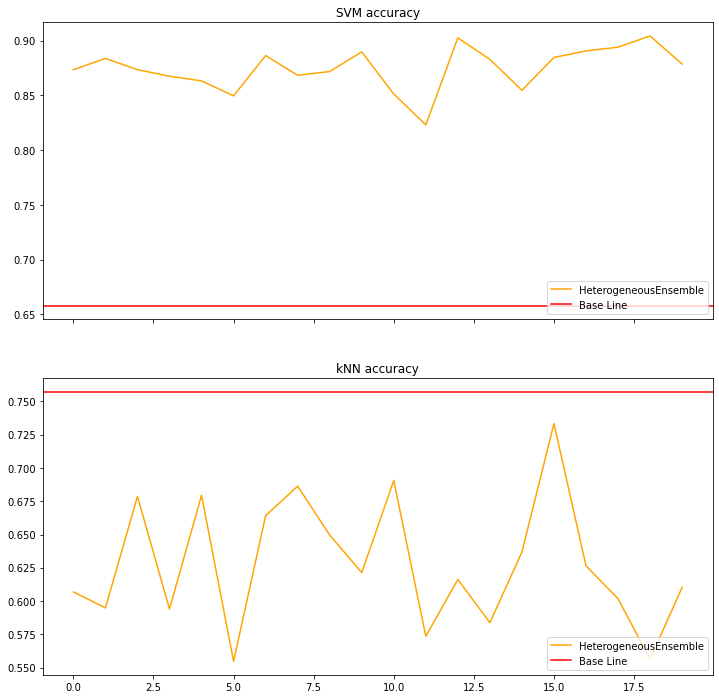

In [27]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12), sharex=True)
x = list(range(0,20))
ax1.plot(x, s_acc_scores, label="HeterogeneousEnsemble", color="orange")
ax1.axhline(y=sv_acc, color='red', label='Base Line')
ax1.legend(loc='lower right')
ax1.set_title("SVM accuracy")
ax2.plot(x, k_acc_scores, label="HeterogeneousEnsemble", color="orange")
ax2.axhline(y=knn_acc, color='red', label='Base Line')
ax2.legend(loc='lower right')
ax2.set_title("kNN accuracy")

Text(0.5, 1.0, 'kNN F1')

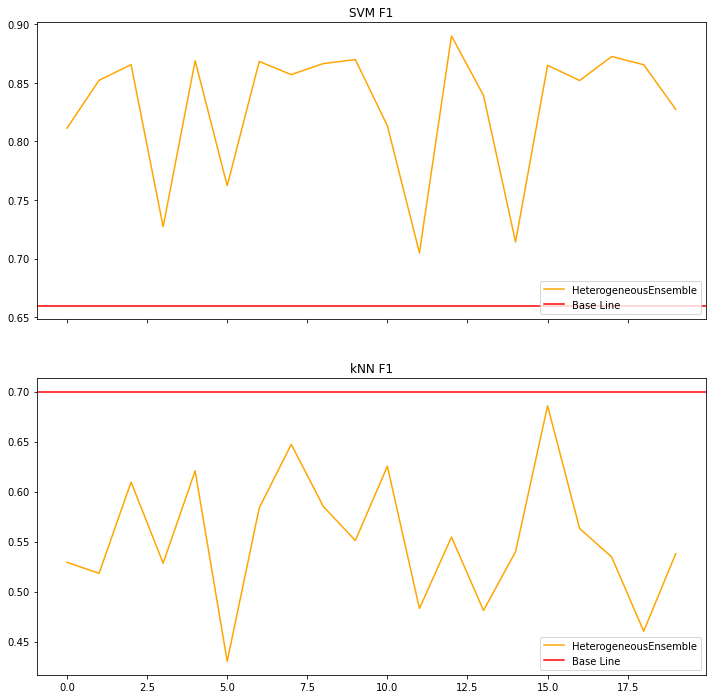

In [58]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12), sharex=True)
x = list(range(0,20))
ax1.plot(x, s_f1_scores, label="HeterogeneousEnsemble", color="orange")
ax1.axhline(y=sv_f1, color='red', label='Base Line')
ax1.legend(loc='lower right')
ax1.set_title("SVM F1")
ax2.plot(x, k_f1_scores, label="HeterogeneousEnsemble", color="orange")
ax2.axhline(y=knn_f1, color='red', label='Base Line')
ax2.legend(loc='lower right')
ax2.set_title("kNN F1")

In [143]:
clf = svm.SVC(random_state=i)
sv_acc = (cross_val_score(clf, X_valid, y_valid, cv=5).mean())
sv_f1 = (cross_val_score(clf, X_valid, y_valid, cv=5, scoring='f1_macro').mean())

sv_acc_10 = []
sv_f1_10 = []
sv_acc_50 = []
sv_f1_50 = []
for i in range(reps, reps+reps):
    clf = HeterogenousEnsembleClassifier(base_estimator=models['SVM'], hp_range_map=hparams['SVM'], n_estimators=10, random_state=i)
    sv_acc_10.append(cross_val_score(clf, X_valid, y_valid, cv=5).mean())
    sv_f1_10.append(cross_val_score(clf, X_valid, y_valid, cv=5, scoring='f1_macro').mean())
    clf = HeterogenousEnsembleClassifier(base_estimator=models['SVM'], hp_range_map=hparams['SVM'], n_estimators=50, random_state=i)
    sv_acc_50.append(cross_val_score(clf, X_valid, y_valid, cv=5).mean())
    sv_f1_50.append(cross_val_score(clf, X_valid, y_valid, cv=5, scoring='f1_macro').mean())




Text(0.5, 1.0, 'F1 scores')

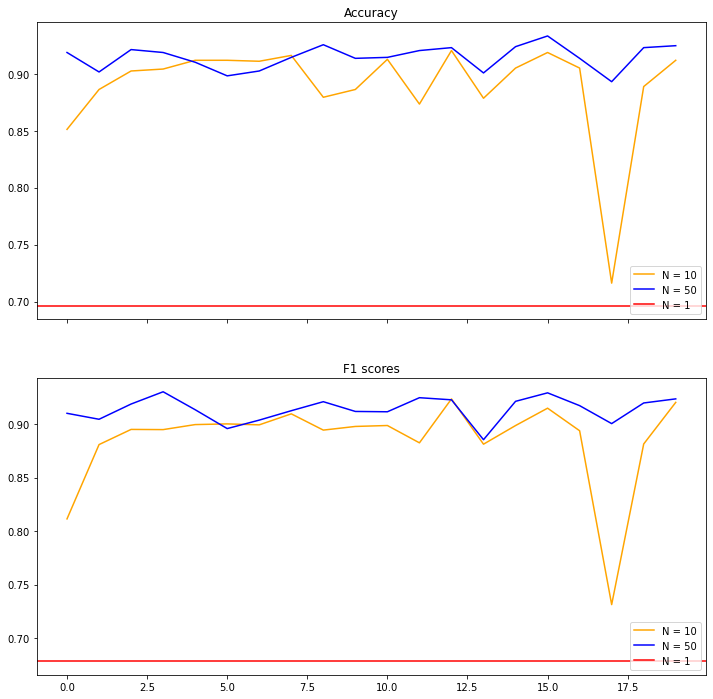

In [147]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12), sharex=True)
x = list(range(0,20))
ax1.plot(x, sv_acc_10, label="N = 10", color="orange")
ax1.plot(x, sv_acc_50, label="N = 50", color="blue")

ax1.axhline(y=sv_acc, color='red', label='N = 1')
ax1.legend(loc='lower right')
ax1.set_title("Accuracy")
ax2.plot(x, sv_f1_10, label="N = 10", color="orange")
ax2.plot(x, sv_f1_50, label="N = 50", color="blue")
ax2.axhline(y=sv_f1, color='red', label='N = 1')
ax2.legend(loc='lower right')
ax2.set_title("F1 scores")

In [157]:
# model_results = pd.DataFrame(columns=['Classifier', 'N_estimators','Accuracy', 'F1', 'Recall'])
# i = 0
# for m in models:
#     clf = copy(models[m])
#     y_pred = clf.fit(X_train, y_train).predict(X_valid)
#     model_results.loc[i] = [m + ' Single', 0] + evaluate_model(y_pred, y_valid)
#     i += 1
#     for n in [5, 10, 20, 50]:
#         clf = HeterogenousEnsembleClassifier(base_estimator=models[m], hp_range_map=hparams[m], n_estimators=n, random_state=1)
#         y_pred = clf.fit(X_train, y_train).predict(X_valid)
#         model_results.loc[i] = [m, n] + evaluate_model(y_pred, y_valid)
#         i += 1

### Perform Evaluation Experiment

-- First of all evaluate best classifier on the data with non stacked model

-- Then use the same base classifier with varying different stacked estimators

-- Then compare against 

## Task 4: Reflect on the Performance of the Different Models Evaluated

*Write your refelcection here (max 300 words)*